WARNING: Kernel fails to automatically score if more than one file is saved to disk. You can still download and manually submit prediction. To allow model/spectrograms saving, change setting below.

In [1]:
save_to_disk = 0

Generating Mel spectrograms for training from true positive data

In [2]:
import csv
import librosa
import numpy as np
from skimage.transform import resize
from PIL import Image
from tqdm.notebook import tqdm_notebook as tqdm

In [3]:

fft = 2048 # (default)
hop = 512 # (default)
# Less rounding errors this way
sr = 48000
length = 10 * sr

with open('../data/train_tp.csv') as f:
    reader = csv.reader(f)
    data = list(reader)

# Check minimum/maximum frequencies for bird calls
# Not neccesary, but there are usually plenty of noise in low frequencies, and removing it helps
fmin = 24000
fmax = 0

# Skip header row (recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max) and start from 1 instead of 0
for i in range(1, len(data)):
    if fmin > float(data[i][4]):
        fmin = float(data[i][4])
    if fmax < float(data[i][6]):
        fmax = float(data[i][6])
# Get some safety margin
fmin = int(fmin * 0.9)
fmax = int(fmax * 1.1)
print('Minimum frequency: ' + str(fmin) + ', maximum frequency: ' + str(fmax))


Minimum frequency: 84, maximum frequency: 15056


In [6]:
!mkdir ../data/train_bmp/

mkdir: cannot create directory ‘../data/train_bmp/’: File exists


In [7]:

print('Starting spectrogram generation')
for i in tqdm(range(1, len(data))):
    # All sound files are 48000 bitrate, no need to slowly resample
    wav, sr = librosa.load('../data/train/' + data[i][0] + '.flac', sr=None)
    
    t_min = float(data[i][3]) * sr
    t_max = float(data[i][5]) * sr
    
    # Positioning sound slice
    center = np.round((t_min + t_max) / 2)
    beginning = center - length / 2
    if beginning < 0:
        beginning = 0
    
    ending = beginning + length
    if ending > len(wav):
        ending = len(wav)
        beginning = ending - length
        
    slice = wav[int(beginning):int(ending)]
    
    # Mel spectrogram generation
    # Default settings were bad, parameters are adjusted to generate somewhat reasonable quality images
    # The better your images are, the better your neural net would perform
    # You can also use librosa.stft + librosa.amplitude_to_db instead
    mel_spec = librosa.feature.melspectrogram(slice, n_fft=fft, hop_length=hop, sr=sr, fmin=fmin, fmax=fmax, power=1.5)
    mel_spec = resize(mel_spec, (224, 400))
    
    # Normalize to 0...1 - this is what goes into neural net
    mel_spec = mel_spec - np.min(mel_spec)
    mel_spec = mel_spec / np.max(mel_spec)

    # And this 0...255 is for the saving in bmp format
    mel_spec = mel_spec * 255
    mel_spec = np.round(mel_spec)    
    mel_spec = mel_spec.astype('uint8')
    mel_spec = np.asarray(mel_spec)
    
    bmp = Image.fromarray(mel_spec, 'L')
    bmp.save('../data/train_bmp/' + data[i][0] + '_' + data[i][1] + '_' + str(center) + '.bmp')
    
#     if i % 100 == 0:
#         print('Processed ' + str(i) + ' train examples from ' + str(len(data)))
    
#     break


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Starting spectrogram generation


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [18]:
'../data/train_bmp/' + data[i][0] + '_' + data[i][1] + '_' + str(center) + '.bmp'

'../data/train_bmp/003bec244_14_2152193.0.bmp'

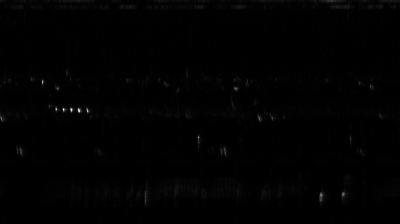

In [9]:
bmp

In [14]:
bmp.size, wav.shape, t_min, t_max

((400, 224), (2880000,), 2138112.0, 2166273.6)

In [15]:
mel_spec.min(), mel_spec.max()

(0, 255)

Settings and random seeds initialization for reproducible results

In [3]:
import os
import torch
import random

num_birds = 24
# 6GB GPU-friendly (~4 GB used by model)
# Increase if neccesary
batch_size = 16

# This is enough to exactly reproduce results on local machine (Windows / Turing GPU)
# Kaggle GPU kernels (Linux / Pascal GPU) are not deterministic even with random seeds set
# Your score might vary a lot (~up to 0.05) on a different runs due to picking different epochs to submit
rng_seed = 1234
random.seed(rng_seed)
np.random.seed(rng_seed)
os.environ['PYTHONHASHSEED'] = str(rng_seed)
torch.manual_seed(rng_seed)
torch.cuda.manual_seed(rng_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Model dataset class

In [4]:
import torch.utils.data as torchdata

class RainforestDataset(torchdata.Dataset):
    def __init__(self, filelist):
        self.specs = []
        self.labels = []
        for f in filelist:
            # Easier to pass species in filename at the start; worth changing later to more capable method
            label = int(str.split(f, '_')[1])
            label_array = np.zeros(num_birds, dtype=np.single)
            label_array[label] = 1.
            self.labels.append(label_array)
            
            # Open and save spectrogram to memory
            
            # If you use more spectrograms (add train_fp, for example), then they would not all fit to memory
            # In this case you should load them on the fly in __getitem__
            img = Image.open('../data/train_bmp/' + f)
            mel_spec = np.array(img)
            img.close()
            
            # Transforming spectrogram from bmp to 0..1 array
            mel_spec = mel_spec / 255
            # Stacking for 3-channel image for resnet
            mel_spec = np.stack((mel_spec, mel_spec, mel_spec))
            
            self.specs.append(mel_spec)
    
    def __len__(self):
        return len(self.specs)
    
    def __getitem__(self, item):
        # Augment here if you want
        return self.specs[item], self.labels[item]

AgsNOTE: You need to get image in [0-1] range before normalizing it with imagenet weights

Split training set on training and validation  
  
What StratifiedKFold does:  
![StratifiedKFold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_003.png)

In [5]:
file_list = []
label_list = []

for f in os.listdir('../data/train_bmp/'):
    if '.bmp' in f:
        file_list.append(f)
        label = str.split(f, '_')[1]
        label_list.append(label)


from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng_seed)

train_files = []
val_files = []

for fold_id, (train_index, val_index) in enumerate(skf.split(file_list, label_list)):
    # Picking only first fold to train/val on
    # This means loss of 20% training data
    # To avoid this, you can train 5 different models on 5 folds and average predictions
    if fold_id == 0:
        train_files = np.take(file_list, train_index)
        val_files = np.take(file_list, val_index)

print('Training on ' + str(len(train_files)) + ' examples')
print('Validating on ' + str(len(val_files)) + ' examples')

Training on 972 examples
Validating on 244 examples


In [6]:
import os

In [7]:
import pandas as pd
df = {
    'file_name': [],
    'label': []
}

# let's create a dataframe
for f in os.listdir('../data/train_bmp/'):
    if '.bmp' in f:
        df['file_name'].append(f)
        label = str.split(f, '_')[1]
        df['label'].append(label)


In [6]:
df = pd.DataFrame(df)

In [7]:
df.head()

,file_name,label
0,54399c91c_18_2597887.0.bmp,18
1,4b406a1bc_4_561154.0.bmp,4
2,ea71a1a7d_12_2078462.0.bmp,12
3,6351581d6_3_2589312.0.bmp,3
4,b8d1e4865_19_2111616.0.bmp,19


In [8]:
# df.to_csv('../data/train_bmp.csv', index=False)

In [48]:
for idx, f in df.iterrows():
    print(f)
    break

file_list     54399c91c_18_2597887.0.bmp
label_list                            18
Name: 0, dtype: object


In [51]:
f['file_list']

'54399c91c_18_2597887.0.bmp'

Preparing everything for training

In [7]:
# !pip install resnest > /dev/null

In [8]:
import torch.nn as nn
from resnest.torch import resnest50

train_dataset = RainforestDataset(train_files)
val_dataset = RainforestDataset(val_files)

train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, sampler=torchdata.RandomSampler(train_dataset))
val_loader = torchdata.DataLoader(val_dataset, batch_size=batch_size, sampler=torchdata.RandomSampler(val_dataset))

In [9]:

# ResNeSt: Split-Attention Networks
# https://arxiv.org/abs/2004.08955
# Significantly outperforms standard Resnet
model = resnest50(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, num_birds)
)

# Picked for this notebook; pick new ones after major changes (such as adding train_fp to train data)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.4)

# This loss function is not exactly suited for competition metric, which only cares about ranking of predictions
# Exploring different loss fuctions would be a good idea
pos_weights = torch.ones(num_birds)
pos_weights = pos_weights * num_birds
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()

Training model on saved spectrograms

In [15]:
best_corrects = 0

get_acc = lambda x: x.sum() / len(x)


# Train loop
print('Starting training loop')
for e in range(0, 32):
    cls_acc = {
        0: [],
        1: []
    }
    # Stats
    train_loss = []
    train_corr = []
    
    # Single epoch - train
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data = data.float()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        
        output = model(data)
        loss = loss_function(output, target)
        
        loss.backward()
        optimizer.step()
        
        # Stats
#         import pdb; pdb.set_trace()
        output = torch.sigmoid(output)
        output = (output > 0.5).type(torch.LongTensor)#.flatten()
        target = target.type(torch.LongTensor)#.latten()
        corrects = (target == output)
        cls_acc[0].append(get_acc(corrects[target==0]))
        cls_acc[1].append(get_acc(corrects[target==1]))




#         vals, answers = torch.max(output, 1)
#         vals, targets = torch.max(target, 1)
#         corrects = 0
#         for i in range(0, len(answers)):
#             if answers[i] == targets[i]:
#                 corrects = corrects + 1
#         train_corr.append(corrects)
        
        train_loss.append(loss.item())
    
    # Stats
    for g in optimizer.param_groups:
        lr = g['lr']
    print('Epoch ' + str(e) + ' training end. LR: ' + str(lr) + ', Loss: ' + str(sum(train_loss) / len(train_loss)))# +
          #', Correct answers: ' + str(sum(train_corr)) + '/' + str(train_dataset.__len__()))
    print('class 0 acc:', np.mean(cls_acc[0]))
    print('class 1 acc:', np.mean(cls_acc[1]))
        
    
    # Single epoch - validation
    with torch.no_grad():
        # Stats
        val_loss = []
        val_corr = []
        
        model.eval()
        for batch, (data, target) in enumerate(val_loader):
            data = data.float()
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = loss_function(output, target)
            
            # Stats
            vals, answers = torch.max(output, 1) # max value,index for each data point
            vals, targets = torch.max(target, 1)
            corrects = 0
            for i in range(0, len(answers)):
                if answers[i] == targets[i]:
                    corrects = corrects + 1
            val_corr.append(corrects)
        
            val_loss.append(loss.item())
    
    # Stats
    print('Epoch ' + str(e) + ' validation end. LR: ' + str(lr) + ', Loss: ' + str(sum(val_loss) / len(val_loss)) +
          ', Correct answers: ' + str(sum(val_corr)) + '/' + str(val_dataset.__len__()))
    
    # If this epoch is better than previous on validation, save model
    # Validation loss is the more common metric, but in this case our loss is misaligned with competition metric, making accuracy a better metric
    if sum(val_corr) > best_corrects:
        print('Saving new best model at epoch ' + str(e) + ' (' + str(sum(val_corr)) + '/' + str(val_dataset.__len__()) + ')')
        torch.save(model, 'best_model.pt')
        best_corrects = sum(val_corr)
        
    # Call every epoch
    scheduler.step()

# Free memory
del model

Starting training loop
Epoch 0 training end. LR: 0.01, Loss: 1.3143812066218892
class 0 acc: 0.5083749
class 1 acc: 0.6413934
Epoch 0 validation end. LR: 0.01, Loss: 1.2277899160981178, Correct answers: 24/244
Saving new best model at epoch 0 (24/244)
Epoch 1 training end. LR: 0.01, Loss: 1.1539129429176205
class 0 acc: 0.6027115
class 1 acc: 0.7851776
Epoch 1 validation end. LR: 0.01, Loss: 1.0751689597964287, Correct answers: 38/244
Saving new best model at epoch 1 (38/244)
Epoch 2 training end. LR: 0.01, Loss: 0.9916086959057167
class 0 acc: 0.69245964
class 1 acc: 0.8036202
Epoch 2 validation end. LR: 0.01, Loss: 1.0284568183124065, Correct answers: 54/244
Saving new best model at epoch 2 (54/244)
Epoch 3 training end. LR: 0.01, Loss: 0.8792059470395572
class 0 acc: 0.7441642
class 1 acc: 0.83572406
Epoch 3 validation end. LR: 0.01, Loss: 0.8863169997930527, Correct answers: 85/244
Saving new best model at epoch 3 (85/244)
Epoch 4 training end. LR: 0.01, Loss: 0.7263176788072117
cl

KeyboardInterrupt: 

Function to split and load one test file

In [11]:
# Already defined above; for reference

# fft = 2048
# hop = 512
# sr = 48000
# length = 10 * sr

def load_test_file(f):
    wav, sr = librosa.load('../data/test/' + f, sr=None)

    # Split for enough segments to not miss anything
    segments = len(wav) / length
    segments = int(np.ceil(segments))
    
    mel_array = []
    
    for i in range(0, segments):
        # Last segment going from the end
        if (i + 1) * length > len(wav):
            slice = wav[len(wav) - length:len(wav)]
        else:
            slice = wav[i * length:(i + 1) * length]
        
        # Same mel spectrogram as before
        mel_spec = librosa.feature.melspectrogram(slice, n_fft=fft, hop_length=hop, sr=sr, fmin=fmin, fmax=fmax, power=1.5)
        mel_spec = resize(mel_spec, (224, 400))
    
        mel_spec = mel_spec - np.min(mel_spec)
        mel_spec = mel_spec / np.max(mel_spec)
        
        mel_spec = np.stack((mel_spec, mel_spec, mel_spec))

        mel_array.append(mel_spec)
    
    return mel_array

Submitting predictions with best model

In [12]:
# Loading model back
model = resnest50(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, num_birds)
)

model = torch.load('best_model.pt')
model.eval()

# Scoring does not like many files:(
# if save_to_disk == 0:
#     for f in os.listdir('/kaggle/working/'):
#         os.remove('/kaggle/working/' + f)

if torch.cuda.is_available():
    model.cuda()
    
# Prediction loop
print('Starting prediction loop')
with open('submission.csv', 'w', newline='') as csvfile:
    submission_writer = csv.writer(csvfile, delimiter=',')
    submission_writer.writerow(['recording_id','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11',
                               's12','s13','s14','s15','s16','s17','s18','s19','s20','s21','s22','s23'])
    
    test_files = os.listdir('../data/test/')
    print(len(test_files))
    
    # Every test file is split on several chunks and prediction is made for each chunk
    for i in tqdm(range(0, len(test_files))):
        data = load_test_file(test_files[i])
        data = torch.tensor(data)
        data = data.float()
        if torch.cuda.is_available():
            data = data.cuda()

        output = model(data)

        # Taking max prediction from all slices per bird species
        # Usually you want Sigmoid layer here to convert output to probabilities
        # In this competition only relative ranking matters, and not the exact value of prediction, so we can use it directly
        maxed_output = torch.max(output, dim=0)[0]
        maxed_output = maxed_output.cpu().detach()
        
        file_id = str.split(test_files[i], '.')[0]
        write_array = [file_id]
        
        for out in maxed_output:
            write_array.append(out.item())
    
        submission_writer.writerow(write_array)
        
        if i % 100 == 0 and i > 0:
            print('Predicted for ' + str(i) + ' of ' + str(len(test_files) + 1) + ' files')

print('Submission generated')

Starting prediction loop
1992
Predicted for 100 of 1993 files
Predicted for 200 of 1993 files
Predicted for 300 of 1993 files
Predicted for 400 of 1993 files
Predicted for 500 of 1993 files
Predicted for 600 of 1993 files
Predicted for 700 of 1993 files
Predicted for 800 of 1993 files
Predicted for 900 of 1993 files
Predicted for 1000 of 1993 files
Predicted for 1100 of 1993 files
Predicted for 1200 of 1993 files
Predicted for 1300 of 1993 files
Predicted for 1400 of 1993 files
Predicted for 1500 of 1993 files
Predicted for 1600 of 1993 files
Predicted for 1700 of 1993 files
Predicted for 1800 of 1993 files
Predicted for 1900 of 1993 files
Submission generated
